In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from librosa.feature.rhythm import tempo as compute_tempo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import soundfile as sf
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

In [2]:
# Paths
original_root = 'genres'
durations_sec = [1, 2, 3, 5, 6, 10]

# Iterate through each genre subfolder
for genre in os.listdir(original_root):
    genre_path = os.path.join(original_root, genre)
    if not os.path.isdir(genre_path):
        continue

    for duration in durations_sec:
        output_root = f'genres_{duration}sec'
        output_genre_path = os.path.join(output_root, genre)
        os.makedirs(output_genre_path, exist_ok=True)

        # Process each .au file
        for file in os.listdir(genre_path):
            if file.endswith('.au'):
                file_path = os.path.join(genre_path, file)
                audio = AudioSegment.from_file(file_path, format='au')

                # Split into chunks of given duration
                duration_ms = duration * 1000
                num_chunks = len(audio) // duration_ms

                base_name = os.path.splitext(file)[0]
                for i in range(num_chunks):
                    start_ms = i * duration_ms
                    end_ms = start_ms + duration_ms
                    chunk = audio[start_ms:end_ms]

                    output_filename = f"{base_name}_{i}.wav"
                    chunk.export(os.path.join(output_genre_path, output_filename), format="wav")


In [2]:

def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0) #supposedly 13 coeffs is a magic number for speech processing analysis but it can change
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0) #gives 12 data points, one for each key in an octave
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0) #sound brightness
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0) #frequency spread
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0) #noisiness
        rms_energy = np.mean(librosa.feature.rms(y=audio).T, axis=0) #loudness
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0) #frequency where most energy is concentrated

        onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate) #to get tempo
        tempo_value = compute_tempo(onset_envelope=onset_env, sr=sample_rate)[0]

        features = np.hstack([
            mfccs, chroma, spectral_centroid, spectral_bandwidth, zero_crossing_rate,
            rms_energy, spectral_rolloff, [tempo_value]
        ])
        return features

    except Exception as e:
        print(f'Error {file_path}: {e}')
        return None
    

In [ ]:
# Feature column names
mfcc_columns = [f'mfcc_{i}' for i in range(13)]
chroma_columns = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
other_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy', 'spectral_rolloff', 'tempo']
feature_names = mfcc_columns + chroma_columns + other_features

# List of durations to process
durations = [1, 2, 3, 5, 6, 10]

# Loop through each duration
for sec in durations:
    directory_path = f'./genres_{sec}sec/'
    data = []

    print(f"\nProcessing data for: genres_{sec}sec")
    
    for genre_folder in os.listdir(directory_path):
        genre_path = os.path.join(directory_path, genre_folder)
        if os.path.isdir(genre_path):
            print(f"  Genre: {genre_folder}")
            for file_name in os.listdir(genre_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(genre_path, file_name)
                    features = extract_features(file_path)
                    if features is not None:
                        data.append([genre_folder, file_name, *features])
    
    # Create and save DataFrame
    df = pd.DataFrame(data, columns=['genre', 'filename'] + feature_names)
    df = df.round(3)
    output_csv = f'audio_features_{sec}sec.csv'
    df.to_csv(output_csv, index=False)
    print(f"Saved {output_csv} with {len(df)} rows")

In [3]:
# Function to extract the 5-digit number
def extract_number(filename):
    return filename.split('.')[1].split('_')[0]

In [4]:
def split_by_number(df, feature_cols=None, test_size=0.2, random_state=42):
    """
    Split the dataset based on 'number' per genre into train and test sets.

    Parameters:
        df (DataFrame): Your full dataframe containing 'genre', 'filename', 'number', and feature columns.
        feature_cols (list or None): List of feature column names to use. 
                                     If None, will use all columns except ['genre', 'filename', 'number'].
        test_size (float): Proportion of the test set (default 0.2 = 20%).
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train, X_test, y_train, y_test
    """

    train_indices = []
    test_indices = []

    for genre in df['genre'].unique():
        genre_df = df[df['genre'] == genre]
        unique_numbers = genre_df['number'].unique()

        # Split numbers into train/test
        train_numbers, test_numbers = train_test_split(
            unique_numbers, test_size=test_size, random_state=random_state
        )

        # Select samples based on numbers
        train_indices.extend(genre_df[genre_df['number'].isin(train_numbers)].index)
        test_indices.extend(genre_df[genre_df['number'].isin(test_numbers)].index)

    # Build train/test DataFrames
    train_df = df.loc[train_indices]
    test_df = df.loc[test_indices]

    #display(train_df.head(20))

    # Feature columns
    if feature_cols is None:
        feature_cols = [col for col in df.columns if col not in ['genre', 'filename', 'number']]

    # Split into X and y
    X_train = train_df[feature_cols]
    y_train = train_df['genre']

    X_test = test_df[feature_cols]
    y_test = test_df['genre']

    return X_train, X_test, y_train, y_test



=== Sampling Duration: 1 sec ===

KNN Accuracy: 0.516

SVM Accuracy: 0.612

Logistic Regression Accuracy: 0.535

=== Sampling Duration: 2 sec ===

KNN Accuracy: 0.544

SVM Accuracy: 0.622

Logistic Regression Accuracy: 0.555

=== Sampling Duration: 3 sec ===

KNN Accuracy: 0.549

SVM Accuracy: 0.625

Logistic Regression Accuracy: 0.552

=== Sampling Duration: 5 sec ===

KNN Accuracy: 0.564

SVM Accuracy: 0.624

Logistic Regression Accuracy: 0.575

=== Sampling Duration: 6 sec ===

KNN Accuracy: 0.547

SVM Accuracy: 0.616

Logistic Regression Accuracy: 0.567

=== Sampling Duration: 10 sec ===

KNN Accuracy: 0.575

SVM Accuracy: 0.610

Logistic Regression Accuracy: 0.589


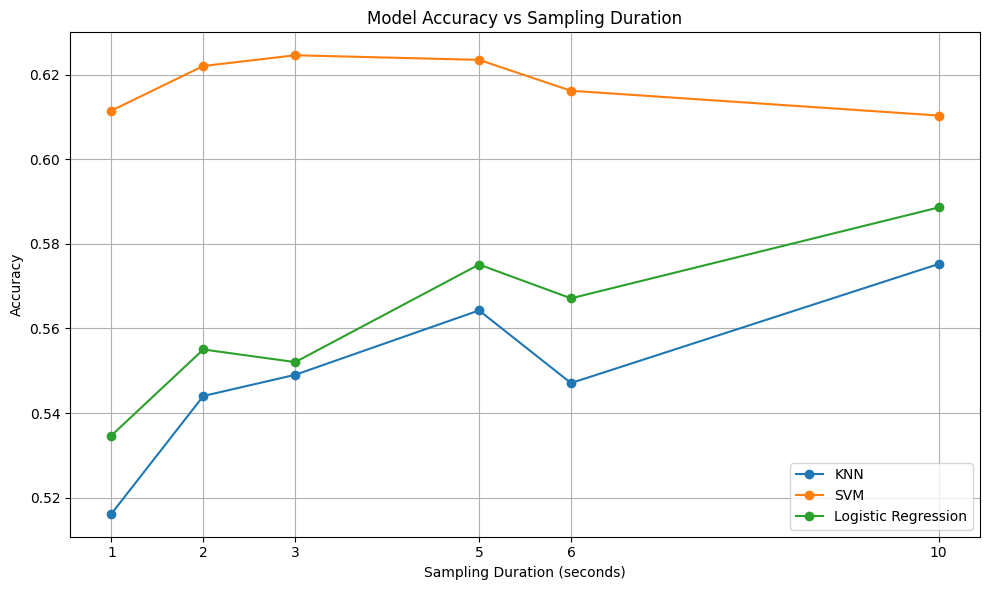

In [25]:
# Sampling durations
durations = [1, 2, 3, 5, 6, 10]

# Models to evaluate
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', C=1, gamma='scale'),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Store accuracies
results = {model_name: [] for model_name in models}

# Loop through each CSV file
for sec in durations:
    file_path = f'audio_features_{sec}sec.csv'
    print(f'\n=== Sampling Duration: {sec} sec ===')

    # Load dataset
    df = pd.read_csv(file_path)
    df['number'] = df['filename'].apply(extract_number)
    
    X_train, X_test, y_train, y_test = split_by_number(df)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        results[name].append(acc)
        print(f'\n{name} Accuracy: {acc:.3f}')
        # Uncomment below to see full report
        # print(classification_report(y_test, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
for name, accs in results.items():
    plt.plot(durations, accs, marker='o', label=name)

plt.title('Model Accuracy vs Sampling Duration')
plt.xlabel('Sampling Duration (seconds)')
plt.ylabel('Accuracy')
plt.xticks(durations)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Load dataset
df = pd.read_csv('audio_features_3sec.csv')
# Check for missing values
missing_counts = df.isnull().sum()
#print("Missing values per column:\n", missing_counts)

# Check for string "nan" in each column
string_nan_counts = (df.astype(str) == 'nan').sum()
#print("Occurrences of string 'nan' per column:\n", string_nan_counts)

# Apply the function and add a new column
df['number'] = df['filename'].apply(extract_number)
#display(df)

In [27]:
X_train, X_test, y_train, y_test = split_by_number(df)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [28]:
# ----------------------------
# KNN Hyperparameter Tuning
# ----------------------------
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) and Euclidean (2)
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

# Best KNN model
best_knn = knn_grid.best_estimator_
knn_pred = best_knn.predict(X_test_scaled)
knn_acc = accuracy_score(y_test, knn_pred)

# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm = svm_grid.best_estimator_
svm_pred = best_svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)


c:\Users\jsmeg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.40347565 0.39972018 0.40047127        nan 0.41936246
 0.40384799 0.40922839        nan 0.42223793 0.40747604 0.41435808
        nan 0.42836864 0.41360691 0.41698582]
  warnings.warn(



=== KNN Model ===
Best Parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Accuracy: 0.586
              precision    recall  f1-score   support

       blues       0.61      0.67      0.64       200
   classical       0.77      0.94      0.84       200
     country       0.52      0.39      0.44       199
       disco       0.41      0.39      0.40       200
      hiphop       0.51      0.51      0.51       199
        jazz       0.57      0.66      0.61       200
       metal       0.82      0.60      0.69       200
         pop       0.63      0.78      0.69       200
      reggae       0.61      0.57      0.59       200
        rock       0.39      0.36      0.37       200

    accuracy                           0.59      1998
   macro avg       0.58      0.59      0.58      1998
weighted avg       0.58      0.59      0.58      1998


=== SVM Model ===
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.642
              precision    recall  f1-score  

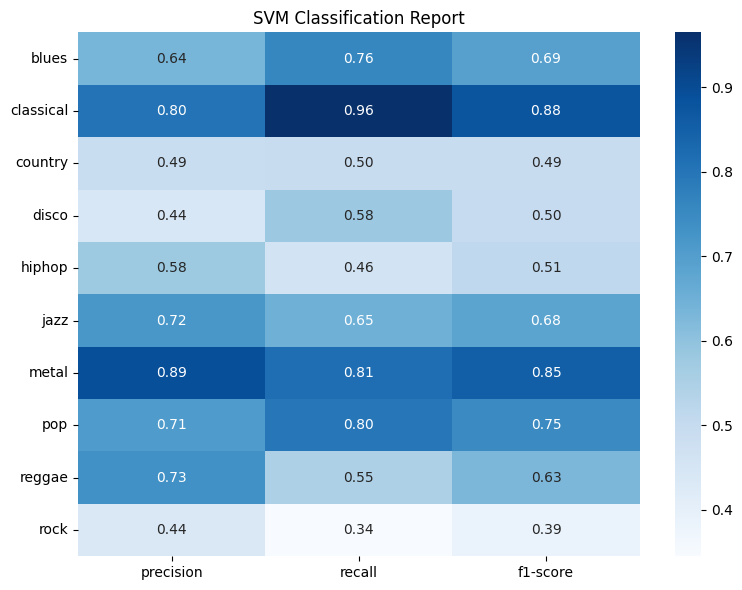

In [29]:
print("\n=== KNN Model ===")
print("Best Parameters:", knn_grid.best_params_)
print(f"Accuracy: {knn_acc:.3f}")
print(classification_report(y_test, knn_pred))

print("\n=== SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_acc:.3f}")
print(classification_report(y_test, svm_pred))

# Convert classification reports to DataFrame
svm_report = classification_report(y_test, svm_pred, output_dict=True)
svm_df = pd.DataFrame(svm_report).T.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plot heatmaps
plt.figure(figsize=(8, 6))
sns.heatmap(svm_df.iloc[:, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title('SVM Classification Report')
plt.tight_layout()
plt.show()


In [5]:
# Parameters
input_root = 'genres_3sec'
output_root = 'genres_3sec_aug'

# Time-stretching factors (e.g., 0.9 is slower, 1.1 is faster)
stretch_rates = [0.9, 1.1]

# Pitch shifting (in semitones)
pitch_steps = [-2, 2]

# Create output directory
os.makedirs(output_root, exist_ok=True)

# Loop through genres
for genre in os.listdir(input_root):
    genre_path = os.path.join(input_root, genre)
    if not os.path.isdir(genre_path):
        continue
    
    output_genre_path = os.path.join(output_root, genre)
    os.makedirs(output_genre_path, exist_ok=True)

    for filename in os.listdir(genre_path):
        if not filename.endswith('.wav'):
            continue
        
        file_path = os.path.join(genre_path, filename)
        y, sr = librosa.load(file_path, sr=None, mono=True)

        # Save original
        base_name = os.path.splitext(filename)[0]
        sf.write(os.path.join(output_genre_path, f"{base_name}_original.wav"), y, sr)

        # Time Stretch
        for rate in stretch_rates:
            try:
                y_stretched = librosa.effects.time_stretch(y=y, rate=rate)
                stretch_name = f"{base_name}_stretch_{int(rate*100)}.wav"
                sf.write(os.path.join(output_genre_path, stretch_name), y_stretched, sr)
            except Exception as e:
                print(f"Time stretch error on {filename}: {e}")

        # Pitch Shift
        for n_steps in pitch_steps:
            try:
                y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
                shift_name = f"{base_name}_pitch_{n_steps:+d}.wav"
                sf.write(os.path.join(output_genre_path, shift_name), y_shifted, sr)
            except Exception as e:
                print(f"Pitch shift error on {filename}: {e}")


In [ ]:
def extract_features_ver4(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=64).T, axis=0)  # changed to 64 MFCCs
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)
        rms_energy = np.mean(librosa.feature.rms(y=audio).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0)

        onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
        tempo_value = compute_tempo(onset_envelope=onset_env, sr=sample_rate)[0]

        contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate).T, axis=0)

        features = np.hstack([
            mfccs, 
            chroma, 
            spectral_centroid, 
            spectral_bandwidth, 
            contrast,
            tonnetz,
            zero_crossing_rate,
            rms_energy, 
            spectral_rolloff, 
            [tempo_value]
        ])
        return features

    except Exception as e:
        print(f'Error {file_path}: {e}')
        return None

In [ ]:
directory_path = f'./genres_3sec_aug/'
data = []

print(f"\nProcessing data for: genres_3sec_aug")
    
for genre_folder in os.listdir(directory_path):
    genre_path = os.path.join(directory_path, genre_folder)
    if os.path.isdir(genre_path):
        print(f"  Genre: {genre_folder}")
        for file_name in os.listdir(genre_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(genre_path, file_name)
                features = extract_features_ver4(file_path)
                if features is not None:
                    data.append([genre_folder, file_name, *features])

In [ ]:
mfcc_columns = [f'mfcc_{i}' for i in range(64)]  # changed from 13 to 64
chroma_columns = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
contrast_columns = [f'contrast_{i}' for i in range(7)]
tonnetz_columns = [f'tonnetz_{i}' for i in range(6)]
other_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy', 'spectral_rolloff', 'tempo']

feature_names = mfcc_columns + chroma_columns + contrast_columns + tonnetz_columns + other_features

# Create and save DataFrame
df = pd.DataFrame(data, columns=['genre', 'filename'] + feature_names)
df = df.round(3)
output_csv = f'audio_new_features_3sec.csv'
df.to_csv(output_csv, index=False)
print(f"Saved {output_csv} with {len(df)} rows")


In [30]:
# Load dataset
df_aug = pd.read_csv('audio_new_features_3sec.csv')
# Check for missing values
missing_counts_aug = df_aug.isnull().sum()
#print("Missing values per column:\n", missing_counts_aug)

# Check for string "nan" in each column
string_nan_counts_aug = (df_aug.astype(str) == 'nan').sum()
#print("Occurrences of string 'nan' per column:\n", string_nan_counts_aug)

# Apply the function and add a new column
df_aug['number'] = df_aug['filename'].apply(extract_number)
df_aug = df_aug.drop(columns=[
    "contrast_0", 
    "contrast_1", 
    "contrast_2", 
    "contrast_3", 
    "contrast_4", 
    "contrast_5", 
    "contrast_6", 
    "tonnetz_0", 
    "tonnetz_1", 
    "tonnetz_2", 
    "tonnetz_3", 
    "tonnetz_4", 
    "tonnetz_5"
    ])

In [6]:
def split_by_number_org(df, feature_cols=None, test_size=0.2, random_state=42):
    """
    Split the dataset based on 'number' per genre into train and test sets.
    Keep only 'original' samples in the test set.

    Returns:
        X_train, X_test, y_train, y_test, filenames_train, filenames_test
    """

    train_indices = []
    test_indices = []

    for genre in df['genre'].unique():
        genre_df = df[df['genre'] == genre]
        unique_numbers = genre_df['number'].unique()

        # Split numbers into train/test
        train_numbers, test_numbers = train_test_split(
            unique_numbers, test_size=test_size, random_state=random_state
        )

        # Add train samples (all augmentations)
        train_indices.extend(genre_df[genre_df['number'].isin(train_numbers)].index)

        # Add only 'original' samples to test set
        test_originals = genre_df[
            (genre_df['number'].isin(test_numbers)) &
            (genre_df['filename'].str.contains('original'))
        ]
        test_indices.extend(test_originals.index)

    # Build train/test DataFrames
    train_df = df.loc[train_indices]
    test_df = df.loc[test_indices]

    # Feature columns
    if feature_cols is None:
        feature_cols = [col for col in df.columns if col not in ['genre', 'filename', 'number']]

    # Split into X, y, and filenames
    X_train = train_df[feature_cols]
    y_train = train_df['genre']
    filenames_train = train_df['filename']

    X_test = test_df[feature_cols]
    y_test = test_df['genre']
    filenames_test = test_df['filename']

    return X_train, X_test, y_train, y_test, filenames_train, filenames_test


In [31]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test = split_by_number_org(df_aug)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:
# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm_aug = svm_grid.best_estimator_
svm_aug_pred = best_svm_aug.predict(X_test_scaled)
svm_aug_acc = accuracy_score(y_test, svm_aug_pred)


=== SVM Model ===
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.704
              precision    recall  f1-score   support

       blues       0.75      0.82      0.78       200
   classical       0.80      0.97      0.88       200
     country       0.58      0.73      0.64       199
       disco       0.58      0.53      0.55       200
      hiphop       0.69      0.66      0.68       199
        jazz       0.79      0.72      0.75       200
       metal       0.92      0.80      0.85       200
         pop       0.59      0.86      0.70       200
      reggae       0.83      0.57      0.68       200
        rock       0.59      0.39      0.47       200

    accuracy                           0.70      1998
   macro avg       0.71      0.70      0.70      1998
weighted avg       0.71      0.70      0.70      1998



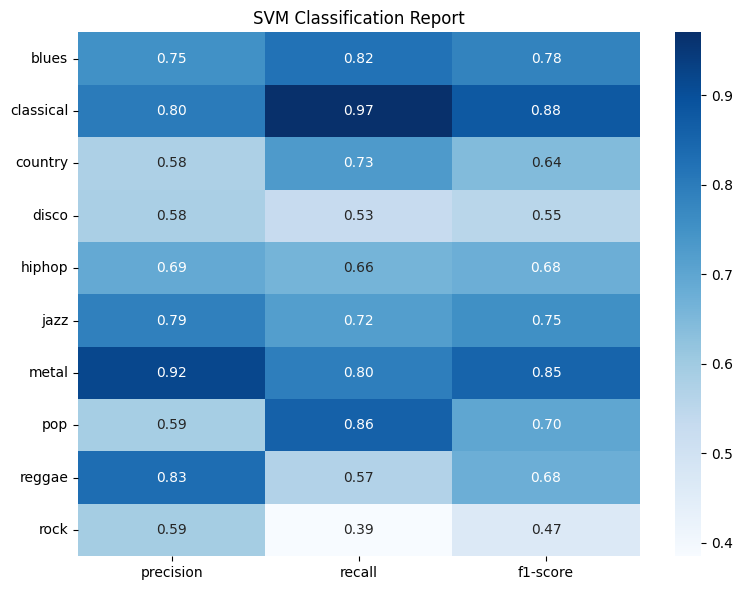

In [33]:
print("\n=== SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_aug_acc:.3f}")
print(classification_report(y_test, svm_aug_pred))

# Convert classification reports to DataFrame
svm_aug_report = classification_report(y_test, svm_aug_pred, output_dict=True)
svm_aug_df = pd.DataFrame(svm_aug_report).T.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plot heatmaps
plt.figure(figsize=(8, 6))
sns.heatmap(svm_aug_df.iloc[:, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title('SVM Classification Report')
plt.tight_layout()
plt.show()

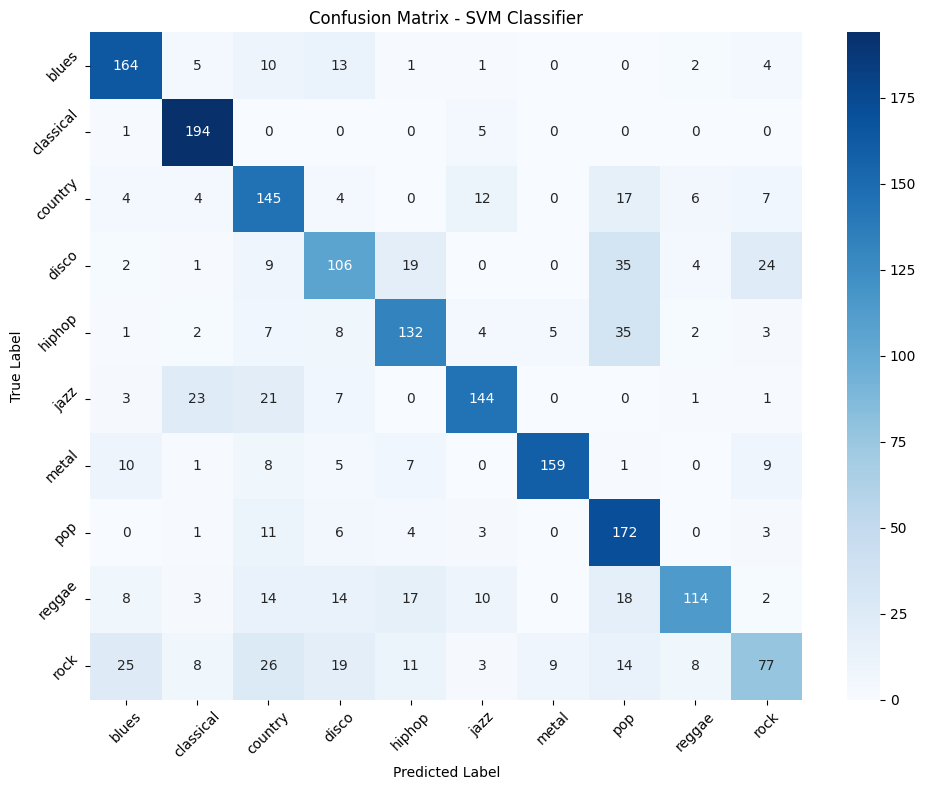

In [34]:
# Compute the confusion matrix
cm_aug = confusion_matrix(y_test, svm_aug_pred, labels=best_svm_aug.classes_)

# Plot using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_svm_aug.classes_,
            yticklabels=best_svm_aug.classes_)
plt.title("Confusion Matrix - SVM Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Load dataset
df_nf = pd.read_csv('audio_new_features_3sec.csv')
# Check for missing values
missing_counts = df_nf.isnull().sum()
#print("Missing values per column:\n", missing_counts)

# Check for string "nan" in each column
string_nan_counts = (df_nf.astype(str) == 'nan').sum()
#print("Occurrences of string 'nan' per column:\n", string_nan_counts)

# Apply the function and add a new column
df_nf['number'] = df_nf['filename'].apply(extract_number)

In [12]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test = split_by_number_org(df_nf)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm_nf = svm_grid.best_estimator_
svm_nf_pred = best_svm_nf.predict(X_test_scaled)
svm_nf_acc = accuracy_score(y_test, svm_nf_pred)


=== SVM Model ===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.729
              precision    recall  f1-score   support

       blues       0.79      0.80      0.79       200
   classical       0.81      0.96      0.88       200
     country       0.59      0.78      0.67       199
       disco       0.70      0.58      0.64       200
      hiphop       0.68      0.73      0.70       199
        jazz       0.79      0.75      0.77       200
       metal       0.92      0.82      0.87       200
         pop       0.65      0.87      0.75       200
      reggae       0.83      0.60      0.70       200
        rock       0.59      0.39      0.47       200

    accuracy                           0.73      1998
   macro avg       0.73      0.73      0.72      1998
weighted avg       0.73      0.73      0.72      1998



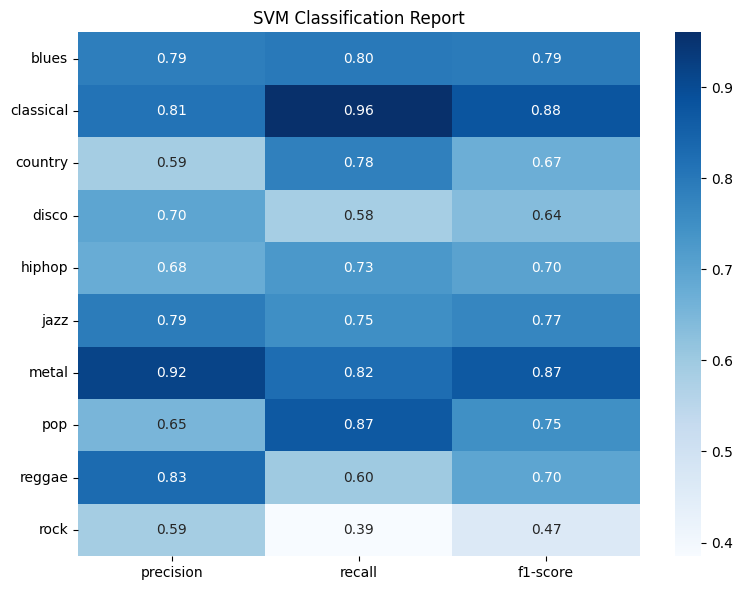

In [15]:
print("\n=== SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_nf_acc:.3f}")
print(classification_report(y_test, svm_nf_pred))

# Convert classification reports to DataFrame
svm_nf_report = classification_report(y_test, svm_nf_pred, output_dict=True)
svm_nf_df = pd.DataFrame(svm_nf_report).T.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plot heatmaps
plt.figure(figsize=(8, 6))
sns.heatmap(svm_nf_df.iloc[:, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title('SVM Classification Report')
plt.tight_layout()
plt.show()

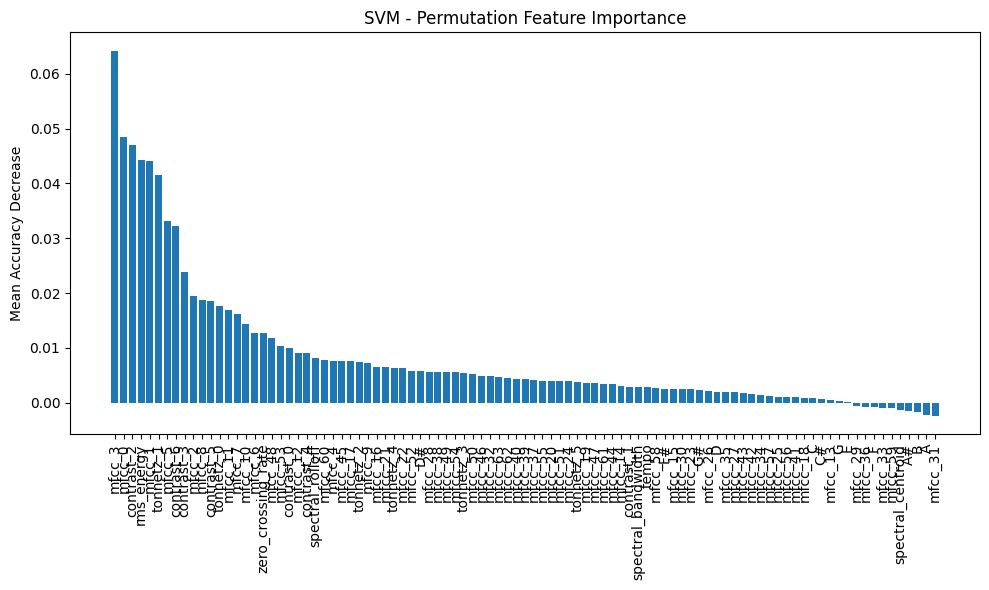

In [16]:
# Get feature names (excluding 'genre' and 'filename')
feature_names = X_test.columns

def plot_feature_importance(importance_result, model_name):
    importances = importance_result.importances_mean
    sorted_idx = importances.argsort()[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_idx], align='center')
    plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
    plt.title(f'{model_name} - Permutation Feature Importance')
    plt.ylabel('Mean Accuracy Decrease')
    plt.tight_layout()
    plt.show()

# -------------------------
# SVM Feature Importance
# -------------------------
svm_nf_importance = permutation_importance(best_svm_nf, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=-1)
plot_feature_importance(svm_nf_importance, "SVM")


In [18]:
# Get importance values
importances = svm_nf_importance.importances_mean

# Find indices where importance is negative
negative_indices = np.where(importances < 0)[0]

# Display feature names and their negative importance
for idx in negative_indices:
    print(f"Feature {feature_names[idx]}: Importance = {importances[idx]:.6f}")

Feature mfcc_29: Importance = -0.000584
Feature mfcc_31: Importance = -0.002369
Feature mfcc_33: Importance = -0.000884
Feature mfcc_36: Importance = -0.000834
Feature mfcc_59: Importance = -0.000934
Feature F: Importance = -0.000868
Feature A: Importance = -0.002286
Feature A#: Importance = -0.001468
Feature B: Importance = -0.001768
Feature spectral_centroid: Importance = -0.001251


In [19]:
df_nf_opt = df_nf.copy()
df_nf_opt = df_nf_opt.drop(columns=[
    "mfcc_29", 
    "mfcc_31", 
    "mfcc_33", 
    "mfcc_36", 
    "mfcc_59", 
    "F", 
    "A", 
    "A#", 
    "B", 
    "spectral_centroid"
    ])


In [20]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test = split_by_number_org(df_nf_opt)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# ----------------------------
# SVM Hyperparameter Tuning
# ----------------------------
svm_params = {
    'C': [1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm_opt = svm_grid.best_estimator_
svm_opt_pred = best_svm_opt.predict(X_test_scaled)
svm_opt_acc = accuracy_score(y_test, svm_opt_pred)


=== SVM Model ===
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.748
              precision    recall  f1-score   support

       blues       0.79      0.85      0.82       200
   classical       0.84      0.95      0.89       200
     country       0.62      0.77      0.69       199
       disco       0.73      0.58      0.65       200
      hiphop       0.70      0.74      0.72       199
        jazz       0.81      0.80      0.80       200
       metal       0.94      0.82      0.87       200
         pop       0.65      0.86      0.74       200
      reggae       0.84      0.62      0.71       200
        rock       0.62      0.47      0.53       200

    accuracy                           0.75      1998
   macro avg       0.75      0.75      0.74      1998
weighted avg       0.75      0.75      0.74      1998



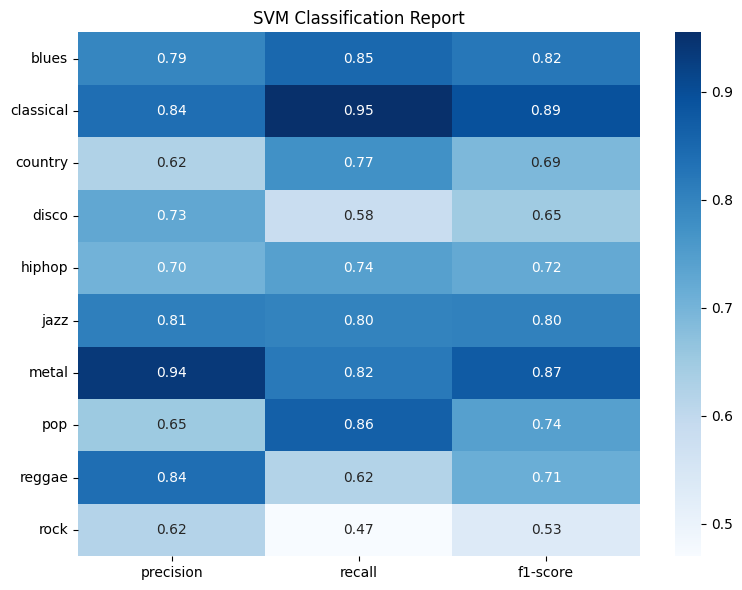

In [22]:
print("\n=== SVM Model ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_opt_acc:.3f}")
print(classification_report(y_test, svm_opt_pred))

# Convert classification reports to DataFrame
svm_opt_report = classification_report(y_test, svm_opt_pred, output_dict=True)
svm_opt_df = pd.DataFrame(svm_opt_report).T.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plot heatmaps
plt.figure(figsize=(8, 6))
sns.heatmap(svm_opt_df.iloc[:, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title('SVM Classification Report')
plt.tight_layout()
plt.show()

In [23]:
# --- Majority Voting Grouped by Original 30-sec File ---
# Extract "base name" = everything before first "_"
def get_base_name(filename):
    parts = filename.split('_')
    return parts[0]  # e.g., blues.00000

base_names = filenames_test.apply(get_base_name)

# Create a DataFrame
results_df = pd.DataFrame({
    'base_name': base_names,
    'true_genre': y_test.values,
    'predicted_genre': svm_opt_pred,
    'filename': filenames_test.values
})

# Group by base_name
final_predictions = []
final_true_labels = []

for base_name, group in results_df.groupby('base_name'):
    majority_vote = Counter(group['predicted_genre']).most_common(1)[0][0]
    true_label = group['true_genre'].mode()[0]  # Take the most common true label
    final_predictions.append(majority_vote)
    final_true_labels.append(true_label)

# Final evaluation
majority_vote_accuracy = accuracy_score(final_true_labels, final_predictions)
print(f"Majority Vote Accuracy (30-sec files): {majority_vote_accuracy:.4f}")


Majority Vote Accuracy (30-sec files): 0.8200


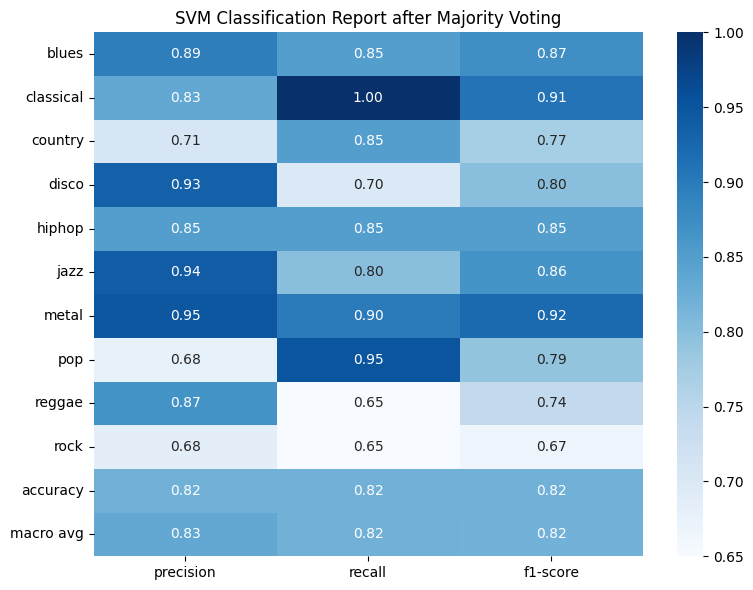

In [24]:
# Create the classification report
report = classification_report(final_true_labels, final_predictions, output_dict=True)
# Turn it into a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")  # Exclude 'accuracy' row and 'support' column
plt.title('SVM Classification Report after Majority Voting')
plt.tight_layout()
plt.show()

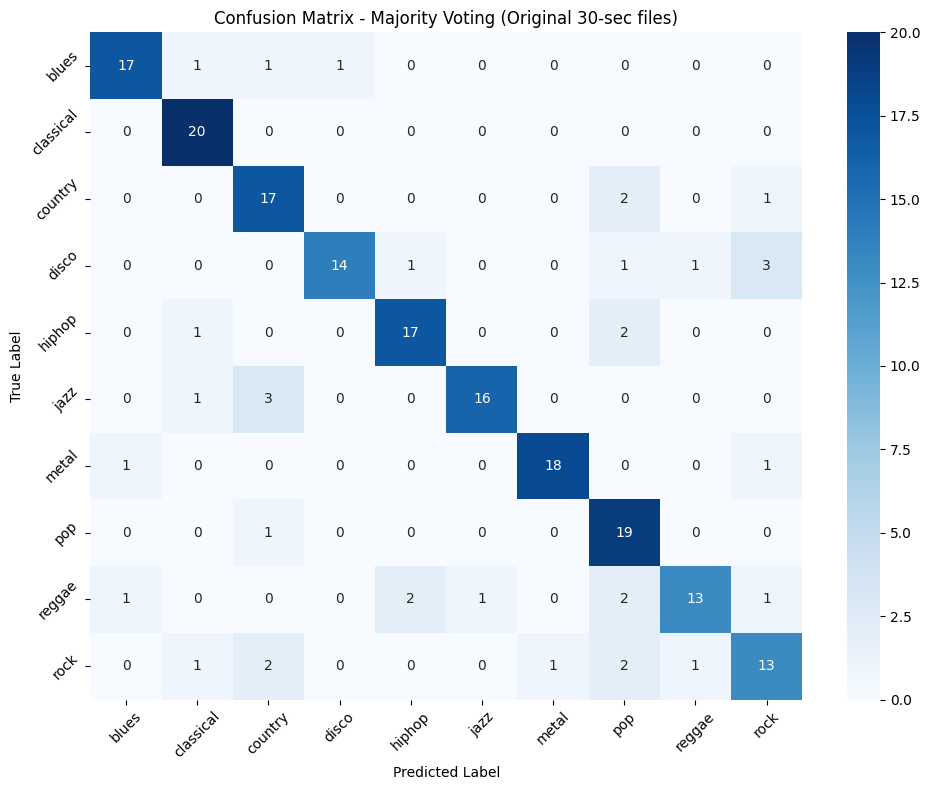

In [25]:
# Confusion Matrix
cm_mv = confusion_matrix(final_true_labels, final_predictions, labels=best_svm_opt.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_mv, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_svm_opt.classes_,
            yticklabels=best_svm_opt.classes_)
plt.title("Confusion Matrix - Majority Voting (Original 30-sec files)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
